In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import h5py
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler


/Users/edgardocrovetto/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Cargar el archivo
file_path = 'dataset_con_metadatos.h5'
with h5py.File(file_path, 'r') as f:
    images = np.array(f['images'])  
    sex = np.array(f['sex'])        
    age = np.array(f['age'])        
    #localization = np.array(f['localization'])  
    labels = np.array(f['classification'])  

In [4]:
# Normalizar el metadato edad
scaler = StandardScaler()
age_normalized = scaler.fit_transform(age.reshape(-1, 1))

# One-Hot Encoding para sexo y localización
encoder = OneHotEncoder(sparse_output=False)
sex_encoded = encoder.fit_transform(sex.reshape(-1, 1))
# localization_encoded = encoder.fit_transform(localization.reshape(-1, 1))

# Concatenar los metadatos
metadata = np.concatenate([age_normalized, sex_encoded], axis=1) #Se quitó la localización porque tiene mucahs más filas que los otros metadatos e imágenes

In [5]:
# Primero, dividir entre entrenamiento (70%) y test+validación (30%)
X_train, X_test, metadata_train, metadata_test, y_train, y_test = train_test_split(
    images, metadata, labels, test_size=0.30, random_state=42)

# Luego dividir la parte test en validación (10%) y prueba (20%)
X_val, X_test, metadata_val, metadata_test, y_val, y_test = train_test_split(
    X_test, metadata_test, y_test, test_size=2/3, random_state=42)

In [6]:
# Convertir etiquetas de one-hot a binario (antes de definir el modelo)
y_train_bin = y_train[:, 1]  # Asumiendo que 'maligno' está en la segunda posición
y_val_bin = y_val[:, 1]
y_test_bin = y_test[:, 1]

In [7]:
from tensorflow.keras import layers, models, regularizers

# Definir las dimensiones de las imágenes
image_height, image_width, channels = images.shape[1], images.shape[2], images.shape[3]

# Definir la entrada de imágenes y la CNN
input_img = layers.Input(shape=(image_height, image_width, channels))
x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_img)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)

# Definir la entrada de metadatos
input_metadata = layers.Input(shape=(metadata_train.shape[1],))
metadata_dense = layers.Dense(64, activation='relu')(input_metadata)

# Combinar las salidas de la CNN y la red densa
combined = layers.concatenate([x, metadata_dense])

# Añadir capas densas finales para la clasificación
z = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(combined)
z = layers.Dropout(0.5)(z)

# Cambiar la salida a una única neurona con activación 'sigmoid'
output = layers.Dense(1, activation='sigmoid')(z)

# Crear el modelo
model_cnn_porcentaje_metadatos = models.Model(inputs=[input_img, input_metadata], outputs=output)

# Compilar el modelo con binary_crossentropy
model_cnn_porcentaje_metadatos.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Mostrar el resumen del modelo
model_cnn_porcentaje_metadatos.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 110, 110,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 55, 55,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 55, 55,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 96800)     │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        256 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 96864)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │  6,199,360 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,200,577 (23.65 MB)

 Trainable params: 6,200,577 (23.65 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Entrenamiento
history = model_cnn_porcentaje_metadatos.fit([X_train, metadata_train], y_train_bin, validation_data=([X_val, metadata_val], y_val_bin), epochs=20, batch_size=32)


Epoch 1/20


/Users/edgardocrovetto/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_5']. Received: the structure of inputs=('*', '*')
  warnings.warn(


132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.5643 - loss: 1.0189 - val_accuracy: 0.6196 - val_loss: 0.6361
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.5800 - loss: 0.6516 - val_accuracy: 0.7010 - val_loss: 0.5862
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.6589 - loss: 0.6014 - val_accuracy: 0.6844 - val_loss: 0.5503
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.6748 - loss: 0.5903 - val_accuracy: 0.7425 - val_loss: 0.5408
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.6904 - loss: 0.5913 - val_accuracy: 0.7193 - val_loss: 0.5557
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.6953 - loss: 0.5649 - val_accuracy: 0.7110 - val_loss: 0.5285
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.7109 - loss: 0.5464 - val_accuracy: 0.7292 - val_loss: 0.5134
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.7173 - loss: 0.5524 - val_accurac

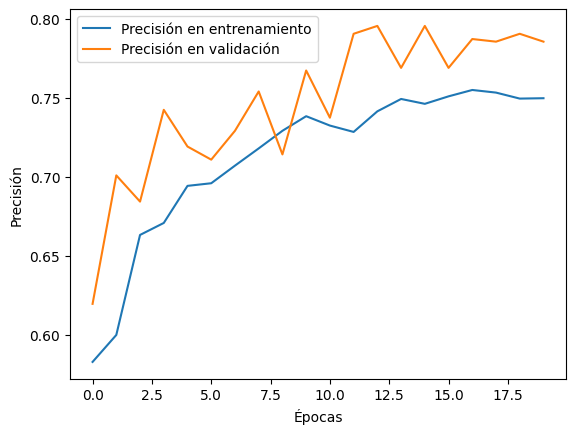

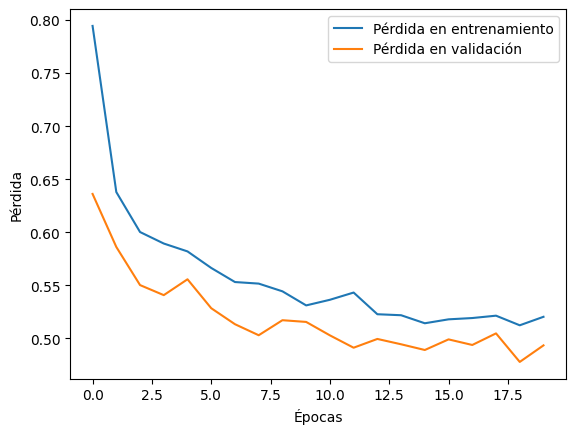

In [9]:
# Curvas de precisión
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Curvas de pérdida
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [10]:
# Obtener probabilidades en el conjunto de prueba
y_pred_prob = model_cnn_porcentaje_metadatos.predict([X_test, metadata_test])

# Mostrar algunas predicciones
print(y_pred_prob[:10])  # Estas son las probabilidades de que las primeras 10 muestras sean malignas


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
[[0.17566963]
 [0.75003076]
 [0.35201102]
 [0.01686997]
 [0.02015834]
 [0.21277517]
 [0.0221735 ]
 [0.00519537]
 [0.5565838 ]
 [0.36175108]]


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


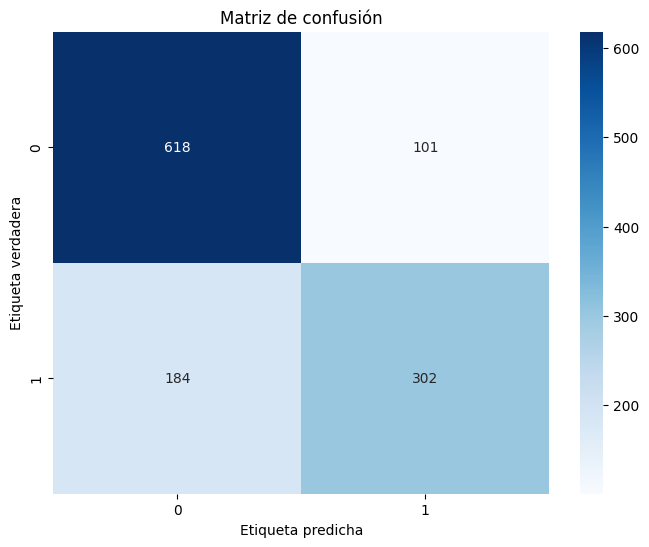

Reporte de clasificación:
               precision    recall  f1-score   support

       False       0.77      0.86      0.81       719
        True       0.75      0.62      0.68       486

    accuracy                           0.76      1205
   macro avg       0.76      0.74      0.75      1205
weighted avg       0.76      0.76      0.76      1205



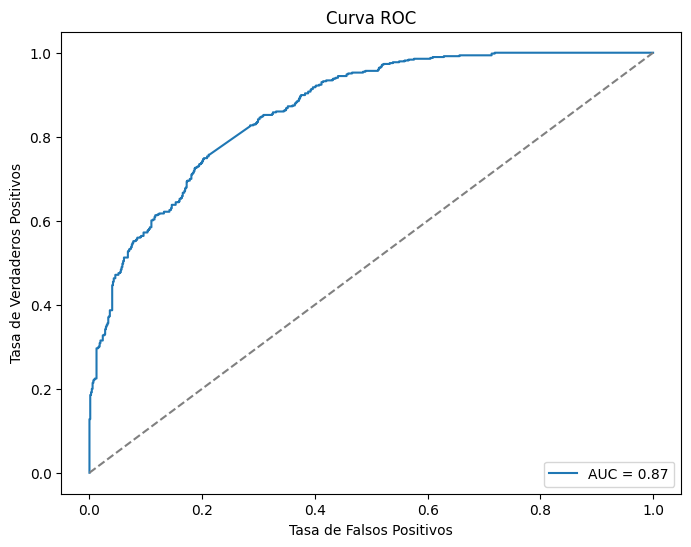

AUC-ROC: 0.87


In [11]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Paso 1: Predicción de probabilidades y clases
# Predecir probabilidades en el conjunto de prueba
y_pred_prob = model_cnn_porcentaje_metadatos.predict([X_test, metadata_test])

# Convertir probabilidades a clases binarias (umbral 0.5)
y_pred_classes = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Las etiquetas verdaderas ya deberían estar en formato binario (0 o 1)
y_true = y_test_bin  # Etiquetas verdaderas en formato binario

# Paso 2: Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Etiqueta verdadera')
plt.xlabel('Etiqueta predicha')
plt.title('Matriz de confusión')
plt.show()

# Paso 3: Reporte de Clasificación (Precisión, Recall, F1-Score)
print("Reporte de clasificación:\n", classification_report(y_true, y_pred_classes))

# Paso 4: Cálculo de AUC-ROC
auc = roc_auc_score(y_true, y_pred_prob)

# Paso 5: Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Línea de referencia (modelo aleatorio)
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Paso 6: Imprimir el AUC
print(f'AUC-ROC: {auc:.2f}')
